### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Loading and splitting the dataset

In [6]:
from sklearn.model_selection import train_test_split

#load dataset into dataframe
df = pd.read_csv('LEC_Winter_Season_2025.csv', sep=';')

# Define early game features manually based
features = ['GD@15', 'CSD@15', 'XPD@15', 'LVLD@15']

# Define and encode the target variable
target = 'Outcome'
df[target] = df[target].map({'Win': 1, 'Loss': 0})


# Features and labels
X = df[[
    'Level', 'Kills', 'Deaths', 'Assists', 'CS', 'CS in Team\'s Jungle', 'CS in Enemy Jungle',
    'CSM', 'Vision Score', 'Wards placed', 'Wards destroyed', 'Control Wards Purchased', 'Detector Wards Placed',
    'DPM', 'DMG%', 'K+A Per Minute', 'Total damage taken', 
    'Total Time Spent Dead', 'Shutdown bounty collected', 
    'Shutdown bounty lost', 'GD@15', 'CSD@15', 'XPD@15', 'LVLD@15'
]]
y = df[target]

print(X.shape)
print(y.shape)

# Handle missing values (if any)
X = X.fillna(method='ffill')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(450, 24)
(450,)


### Data preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# All features are numeric now
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Preprocessor only scales numeric features
preprocessor = StandardScaler()


### Logistic regression model and results

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94        47
           1       0.97      0.88      0.93        43

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90

Confusion Matrix:
 [[46  1]
 [ 5 38]]
Accuracy Score: 0.9333333333333333


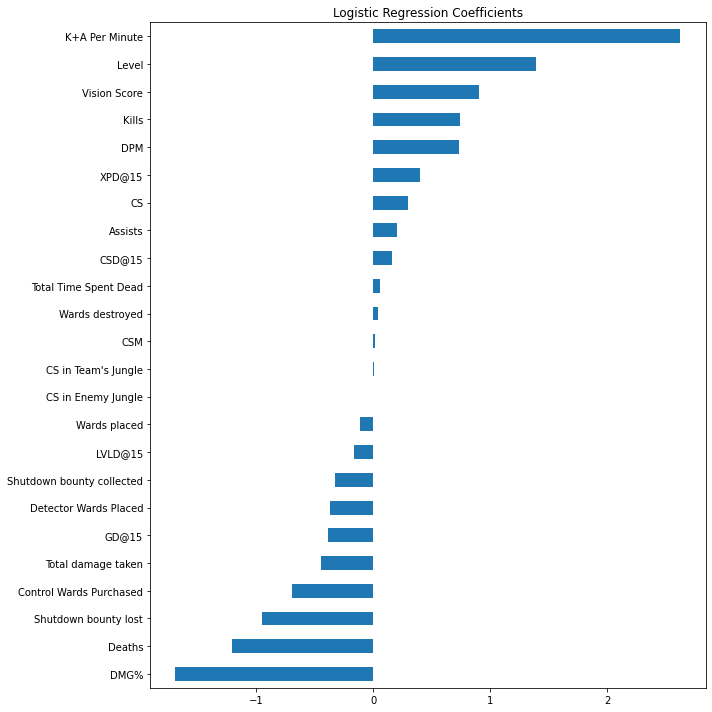

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('logreg', LogisticRegression(max_iter=1000))
])

param_grid = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV 
grid_search = GridSearchCV(logreg_pipeline , param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get best estimator
best_logreg = grid_search.best_estimator_

# Predictions with best model
y_pred_best = best_logreg.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_best ))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best ))
print("Accuracy Score:", accuracy_score(y_test, y_pred_best ))

# Visualize feature importance (coefficients)
plt.figure(figsize=(10, 10))
feature_names = best_logreg.named_steps['preprocessor'].get_feature_names_out()
coefficients = pd.Series(best_logreg.named_steps['logreg'].coef_[0], index=feature_names)
coefficients.sort_values().plot(kind='barh', title='Logistic Regression Coefficients')
plt.tight_layout()
plt.show()

### Random forst model and results

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90        47
           1       0.92      0.84      0.88        43

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90

Confusion Matrix:
 [[44  3]
 [ 7 36]]
Accuracy Score: 0.8888888888888888


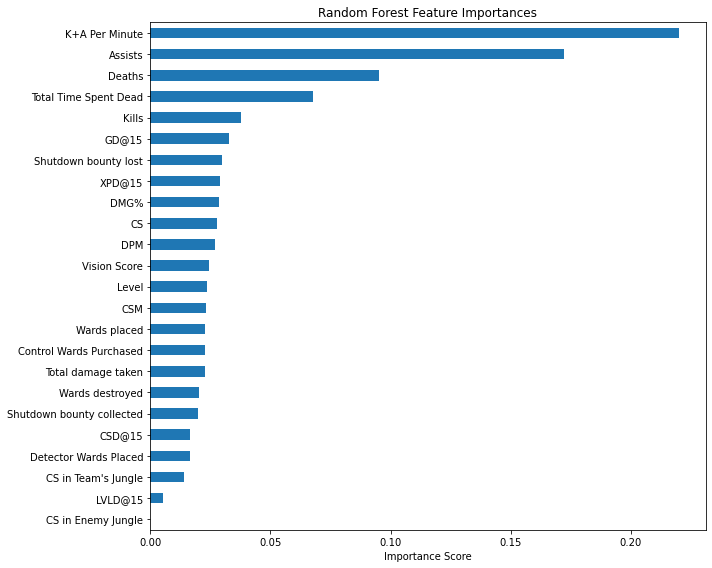

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf_param_grid = {
    "rf__n_estimators": [50, 100, 200], 
    "rf__max_depth": [5, 10, 20],
}
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('rf', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Get best estimator
best_rf = grid_search.best_estimator_

# Predictions with best model
y_pred_best = best_rf.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_best ))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best ))
print("Accuracy Score:", accuracy_score(y_test, y_pred_best ))

# Visualize feature importance (coefficients)
feature_names = best_rf.named_steps['preprocessor'].get_feature_names_out()
importances = best_rf.named_steps['rf'].feature_importances_
importance_series = pd.Series(importances, index=feature_names)
plt.figure(figsize=(10, 8))
importance_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

### Gradient boosting model and results

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93        47
           1       0.95      0.88      0.92        43

    accuracy                           0.92        90
   macro avg       0.93      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90

Confusion Matrix:
 [[45  2]
 [ 5 38]]
Accuracy Score: 0.9222222222222223


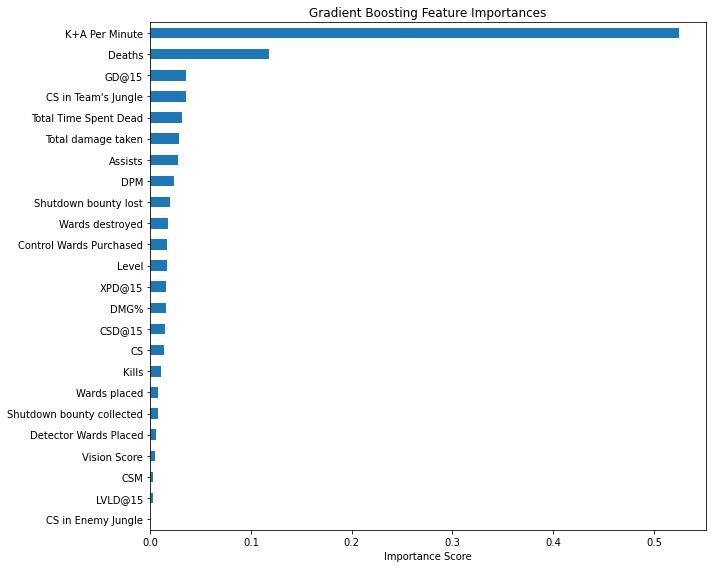

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
#  Define parameter grid
gb_param_grid = {
    "gb__n_estimators": [50, 100, 200],
    "gb__max_depth": [3, 5, 7],
    "gb__learning_rate": [0.01, 0.1, 0.2],
}
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('gb', GradientBoostingClassifier(random_state=42))
])

# Grid search setup
grid_search = GridSearchCV(gb_pipeline,gb_param_grid,cv=5,scoring="accuracy")
grid_search.fit(X_train, y_train)

# Best estimator
best_gb = grid_search.best_estimator_

# Predictions with best model
y_pred_best = best_gb.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_best ))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best ))
print("Accuracy Score:", accuracy_score(y_test, y_pred_best ))

# Visualize feature importance (coefficients)
feature_names = best_gb.named_steps['preprocessor'].get_feature_names_out()
importances = best_gb.named_steps['gb'].feature_importances_
importance_series = pd.Series(importances, index=feature_names)
plt.figure(figsize=(10, 8))
importance_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()